In [24]:
import librosa as lr
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [2]:
# LOAD AUDIO

audio = []
counter = 0

for filename in os.listdir('../sample_audio'):
    print(filename)
    filename, sr = lr.load(f'../sample_audio/{filename}') # sample rate
    counter += 1
    audio.append(filename)

Agnew, Roy, Australian Forest Pieces, 4dRd_HTq6ok.wav
Aguirre, Julián, Gato, w9CjQXt12YA.wav
Aitken, George, Sérénade, Op.17, 1e3XI4ubM98.wav
Alain, Albert, Espagnolerie, ts4pTlWdmMg.wav
Albéniz, Isaac, Barcarola, Op.23, dJ3qmtEcQoA.wav
Alder, Ernest, Valse-caprice, sQ7wZLqvPCs.wav
Alden, Bob, The American Dancers, rsmDH2Zopt0.wav
Ajith, Sriram, Winter Night, Op.1, q5xi-3xarzY.wav
Alburger, Mark, The Twelve Fingers, Op.8, ZUmCV1zUuBw.wav
Akimenko, Theodore, Jeux, Op.34, oT9uPpgqty4.wav


In [3]:
min(audio[0])

-0.06787674

In [4]:
audio[1].shape

(3838208,)

In [5]:
#padded_audio_piece = pad_sequences(audio, dtype='float32', padding='pre', value=-2, maxlen= 1500000) 

In [6]:
len(audio[0])

1484640

In [8]:
# PAD AUDIO 

padded_audio_pieces = []

for piece in audio:
    padded_audio_piece = lr.util.fix_length(piece, size=1500000)
    padded_audio_pieces.append(padded_audio_piece)

In [9]:
# STFT params

FRAME_SIZE = 2048
HOP_SIZE = 342

In [11]:
# First Transformation Short Time Fourier Tranform (STFT)

transformed_audio = []

for song in padded_audio_pieces:
    stft = lr.stft(song, n_fft = FRAME_SIZE-1, hop_length = HOP_SIZE)
    stft = np.abs(stft) ** 2
    transformed_audio.append(stft)

In [12]:
transformed_audio[1].shape

(1024, 4386)

In [18]:
# Plot Spectrogram

def plot_spectrogram(Y, sr, hop_length, y_axis='linear'):
    plt.figure(figsize=(25, 10))
    lr.display.specshow(Y, 
                        sr=sr,
                       hop_length = hop_length,
                       x_axis='time',
                       y_axis=y_axis)
    plt.colorbar(format="%+2.f")

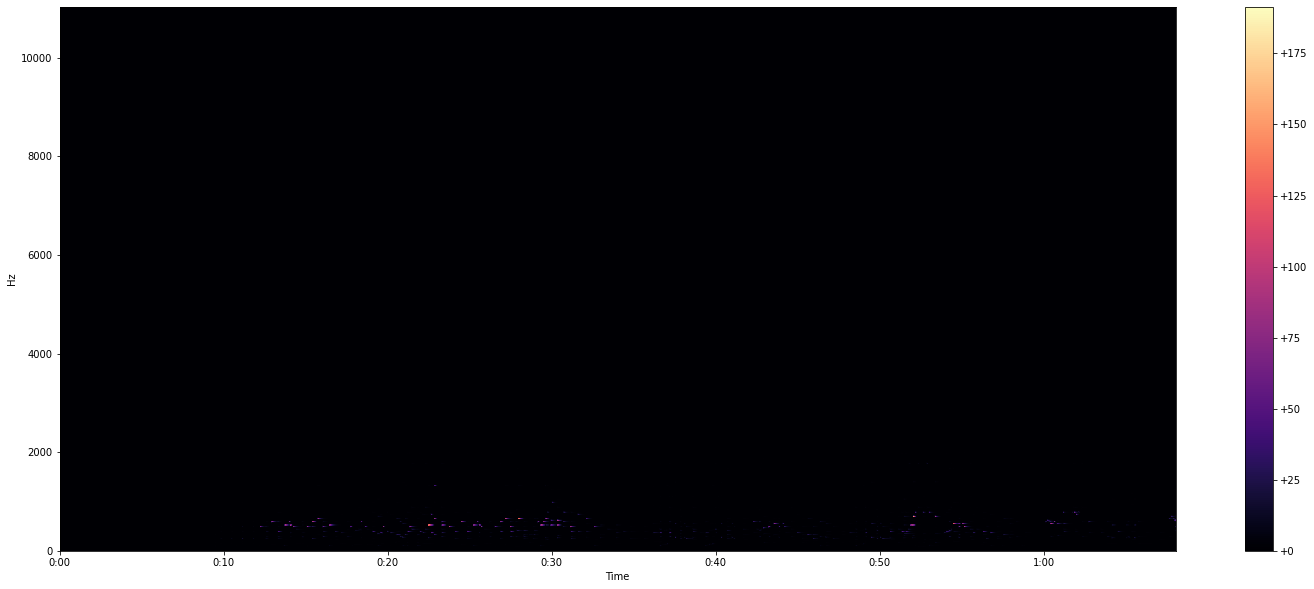

In [19]:
plot_spectrogram(transformed_audio[2],sr ,HOP_SIZE )

In [57]:
# Second Tranformation (power to db)

transformed_log_audio = []
for stft in transformed_audio:
    log_stft = lr.power_to_db(stft)
    transformed_log_audio.append(log_stft)

25.567122

In [56]:

# LOAD SCALER
X_scaler = MinMaxScaler()

# NORMALIZE AUDIO FUNCTION
def normalize_spec(X,scaler):
    '''
    Input spectrogram should be in the shape of (n_samples, n_freqency_bin, n_time_steps)
    or in the shape of (n_samples, 1, n_freqency_bin, n_time_steps)
    '''
    X_norm = []
    if len(X[0].shape) == 3:
        print("Images with channels")
        for spec in X:
            H = spec.shape[1]; W=spec.shape[2]
            norm = scaler.fit_transform(spec.reshape(H*W,1))
            X_norm.append(norm.reshape(H,W))

        X_norm = np.array(X_norm)    

    elif len(X[0].shape) == 2:
        print("Images with H and W")
        for spec in X:
            H = spec.shape[0]; W=spec.shape[1]
            norm = scaler.fit_transform(spec.reshape(H*W,1))
            X_norm.append(norm.reshape(H,W))

        X_norm = np.array(X_norm)

    else:
        print("shape error, please check your input")
    return X_norm

In [59]:
#NORMALIZE AUDIO
normalized_audio = normalize_spec(transformed_log_audio, X_scaler)

Images with H and W


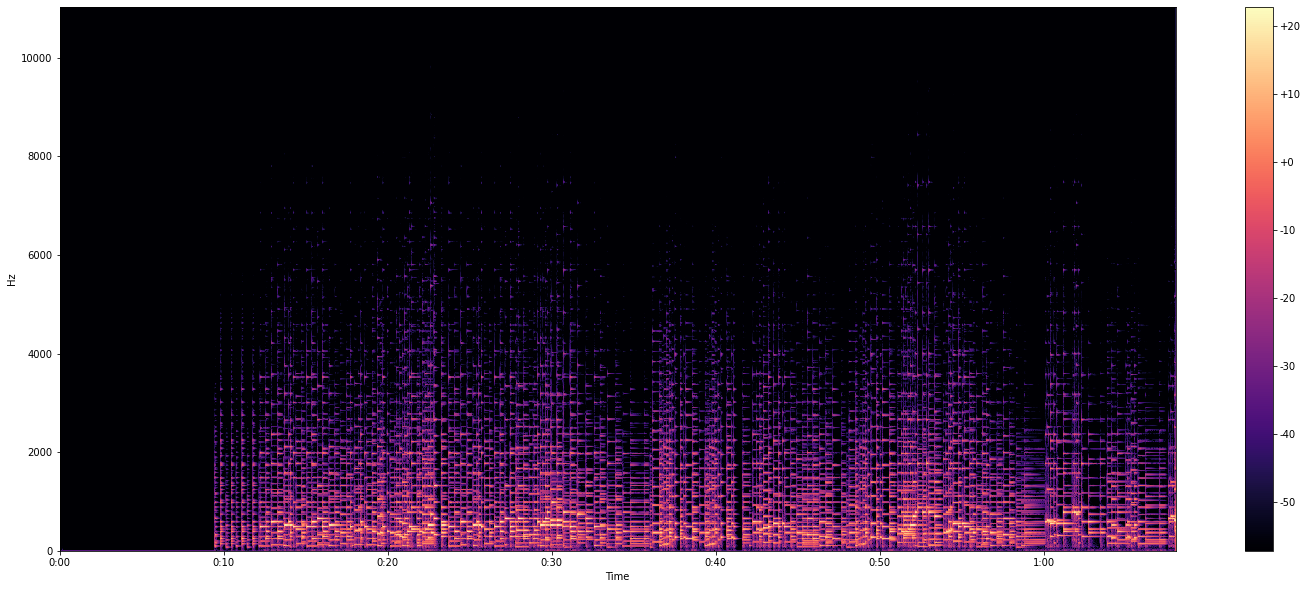

In [22]:
plot_spectrogram(transformed_log_audio[2], sr ,HOP_SIZE, y_axis ='linear' )

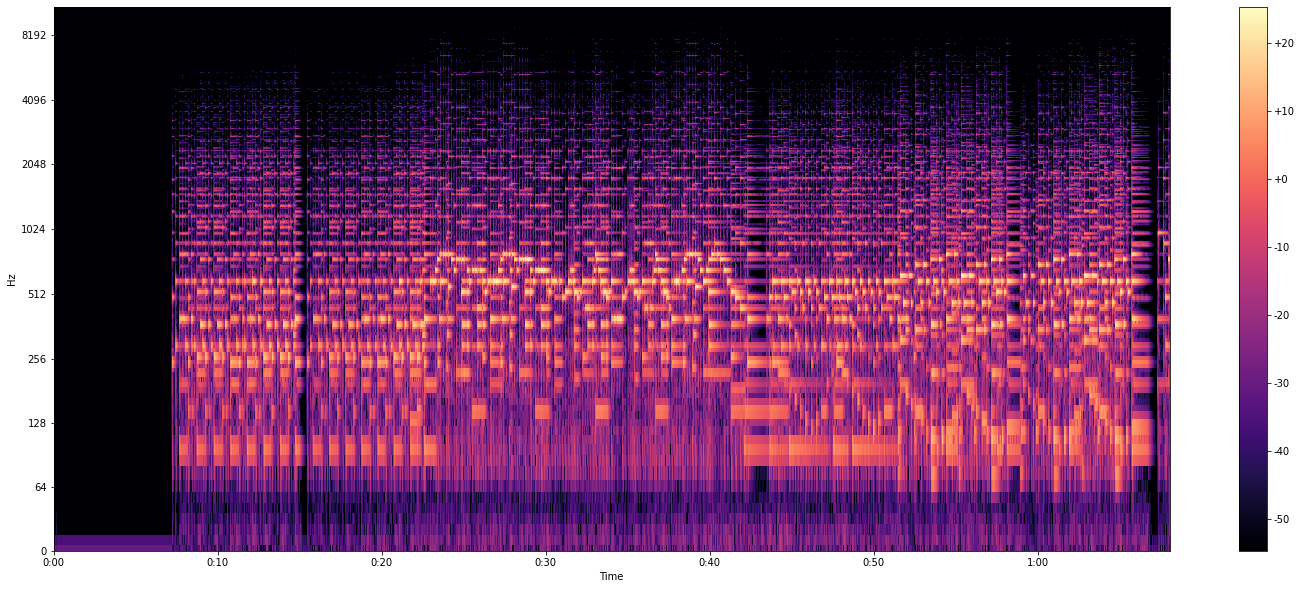

In [23]:
plot_spectrogram(transformed_log_audio[1], sr ,HOP_SIZE, y_axis ='log' )

In [ ]:
# Export converted audio file as numpy array ( .npy file)
counter = 1
for npy in transformed_log_audio:
    np.save(f'../npy_files_padded/npy_file_no{counter}', npy)
    counter += 1

In [16]:
# INVERSE STFT

new_audio = []
for transformed_log_audio_piece in transformed_audio:
    new_audio_piece = lr.istft(transformed_log_audio_piece)
    new_audio.append(new_audio_piece)

In [17]:
# EXPORT INVERSED AUDIO

counter = 1
for inversed_audio_piece in new_audio:

    sf.write(f'_attempted_output_{counter}.wav', inversed_audio_piece, sr)
    counter += 1